In [1]:
'''
Author: ChenHJ
Date: 2022-10-21 16:20:54
LastEditors: ChenHJ
LastEditTime: 2022-10-21 16:21:21
FilePath: /chenhj/self_def/lat_lon_box.ipynb
Aim: 
本程序用于对经纬度范围添加边框
同时将显示地形高度 
Mission: 
'''


'\nAuthor: ChenHJ\nDate: 2022-10-21 16:20:54\nLastEditors: ChenHJ\nLastEditTime: 2022-10-21 16:21:21\nFilePath: /chenhj/self_def/lat_lon_box.ipynb\nAim: \n本程序用于对经纬度范围添加边框\n同时将显示地形高度 \nMission: \n'

In [2]:
# read the surface hgt data
import numpy as np
import xarray as xr
import os
import re
from cdo import Cdo
import shutil
import sys

sys.path.append("/home/ys17-23/chenhj/self_def/")
import plot as sepl
import cal as ca
import pandas as pd
from importlib import reload

# sd.path.append("/home/ys17-23/chenhj/1201code/self_def.py")

cdo = Cdo()

# for plot
import proplot as pplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter
from cartopy.mpl.ticker import LatitudeFormatter
from cartopy.util import add_cyclic_point
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from scipy import stats

reload(ca)

fhgt = xr.open_dataset("/home/ys17-23/chenhj/self_def/hgt.sfc.nc")
hgt = fhgt['hgt'][0,:,:].drop('time')
# mask = 1013.25*(1.0-hgt*0.0065/288.15)**5.25145

/home/soft/anaconda3/envs/chenhj/lib/python3.8/site-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


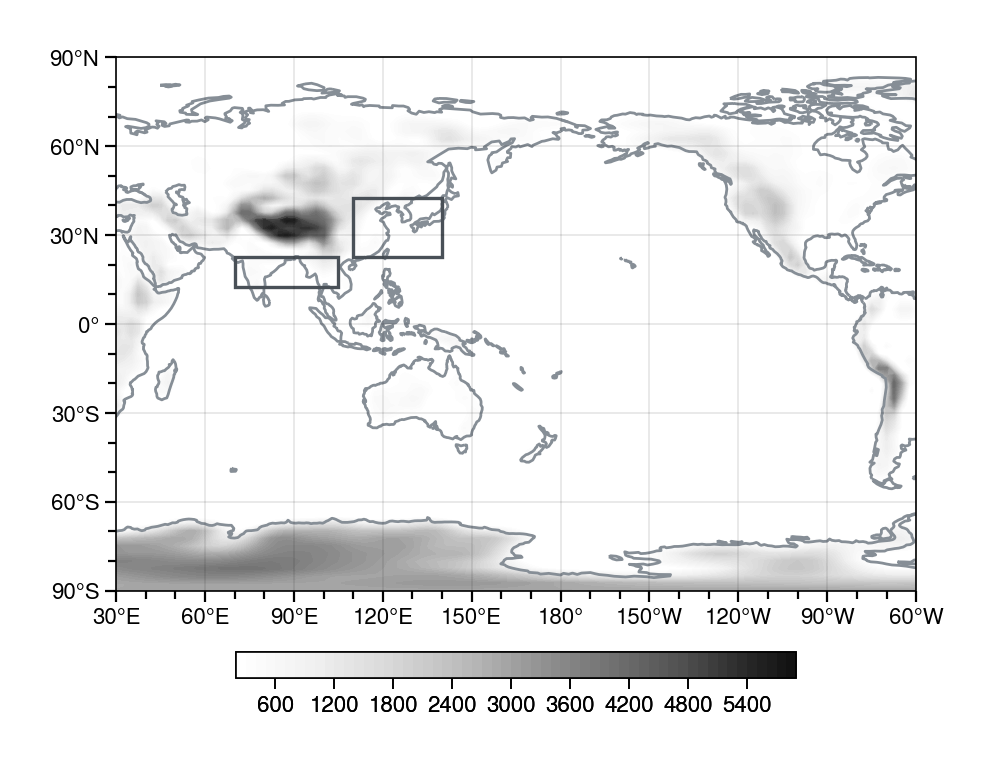

In [30]:
# plot the box


cl = 180  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=3.5, outerpad=2.0)
axs = fig.subplots(ncols=1, nrows=1, proj=proj)

#   set the geo_ticks and map projection to the plots
xticks = np.array([30, 60, 90, 120, 150, 180, 210, 240, 270, 300])
yticks = np.arange(-90, 91, 30)  # 设置纬度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [xticks[0], xticks[1], yticks[0], yticks[1]]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=8, latminorspace=10, coastlinewidth=1.0)
# ===================================================
box_N = 42.5
box_S = 22.5
box_W = 110
box_E = 140


x0 = box_W
y0 = box_S
width = box_E-box_W
height = box_N-box_S
sepl.patches(axs, x0 - cl, y0, width, height, proj, linestyle="-", linewidth=1.2)

box_N = 22.5
box_S = 12.5
box_W = 70
box_E = 105


x0 = box_W
y0 = box_S
width = box_E-box_W
height = box_N-box_S
sepl.patches(axs, x0 - cl, y0, width, height, proj, linestyle="-", linewidth=1.2)

con = axs[0].contourf(
    hgt,
    cmap="greys",
    cmap_kw={"right": 0.94},
    levels=np.arange(200,5901,100),
    zorder=0.8,
    )
cb = fig.colorbar(con, loc="b", width=0.13, length=0.7, label="", ticklabelsize=8)

fig.format(rc_kw={"grid": False, "reso": "lo", "figure.facecolor":"white", "font.large": 13})

In [22]:
# mask = 1013.25*(1.0-hgt*0.0065/288.15)**5.25145   #将地表位势高度转换为大气压值，从而可以进行判断，例如在画850hPa等高面图时，如果某一点上地表大气压值小于850hPa，则说明此处为陆地，需要mask

<xarray.DataArray 'hgt' ()>
array(10512)
Attributes:
    long_name:     4xDaily Geopotential height
    units:         m
    precision:     0
    GRIB_id:       7
    GRIB_name:     HGT
    var_desc:      Geopotential height
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [-583. 5659.]
    valid_range:   [-1200.  6300.]
    dataset:       NCEP Reanalysis